In [4]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

INPUT_DIR = "./data"
FILENAME = ["pfyh.csv", "zjls.csv", "szzz.csv", "gzzs.csv"]
MATCH = {
    "pfyh.csv": "浦发银行",
    "zjls.csv": "浙江龙盛", 
    "szzz.csv": "上证综指",
    "gzzs.csv": "国债指数",
} 

def get_xticks(date_list):
    xticks = []
    for i, date in enumerate(date_list):
        if date[-2:] == "01":
            xticks.append(i)
    return xticks

def read_csv(filepath):
    df = pd.read_csv(filepath)
    df = df.rename(columns={"Unnamed: 0": "date"})
    return df

def get_rate_of_ret():
    sns_table = pd.DataFrame(columns=["name", "date", "rate_of_ret", "rate_of_ret_accumulate"])
    for filename in FILENAME:
        tmp_table = pd.DataFrame(columns=["name", "date", "rate_of_ret"])
        df = read_csv(os.path.join(INPUT_DIR, filename))
        pre_date = "2016-05"
        pre_price = df["open"][0]
        for i in range(len(df)):
            date = df["date"][i]
            date = date[:-3]
            if date != pre_date:
                price = df["close"][i - 1]
                rate_of_ret = price / pre_price - 1
                new = {
                    "name": MATCH[filename],
                    "date": pre_date,
                    "rate_of_ret": rate_of_ret,
                }
                tmp_table = tmp_table.append(new, ignore_index=True)
                pre_price = price
                pre_date = date
        
        # the last month of the data
        price = df["close"][df.index[-1]]
        rate_of_ret = price / pre_price - 1
        new = {
            "name": MATCH[filename],
            "date": pre_date,
            "rate_of_ret": rate_of_ret,
        }
        tmp_table = tmp_table.append(new, ignore_index=True)

        # compute the rate-of-return-accumulate
        accumulate = tmp_table["rate_of_ret"].copy()
        for i in range(1, len(accumulate)):
            accumulate[i] = (1 + accumulate[i - 1]) * (1 + accumulate[i]) - 1
        tmp_table["rate_of_ret_accumulate"] = accumulate

        sns_table = sns_table.append(tmp_table)

    sns_table.to_csv("./data/month_data.csv")

    sns_table["rate_of_ret(%)"] = sns_table["rate_of_ret"] * 100
    sns_table["rate_of_ret_accumulate(%)"] = sns_table["rate_of_ret_accumulate"] * 100
    return sns_table[["name", "date", "rate_of_ret(%)", "rate_of_ret_accumulate(%)"]]

   name     date  rate_of_ret(%)  rate_of_ret_accumulate(%)
0  浦发银行  2016-05        1.917546                   1.917546
1  浦发银行  2016-06       -3.574788                  -1.725791
2  浦发银行  2016-07        0.780488                  -0.958773
3  浦发银行  2016-08        5.033882                   4.026846
4  浦发银行  2016-09        0.000000                   4.026846


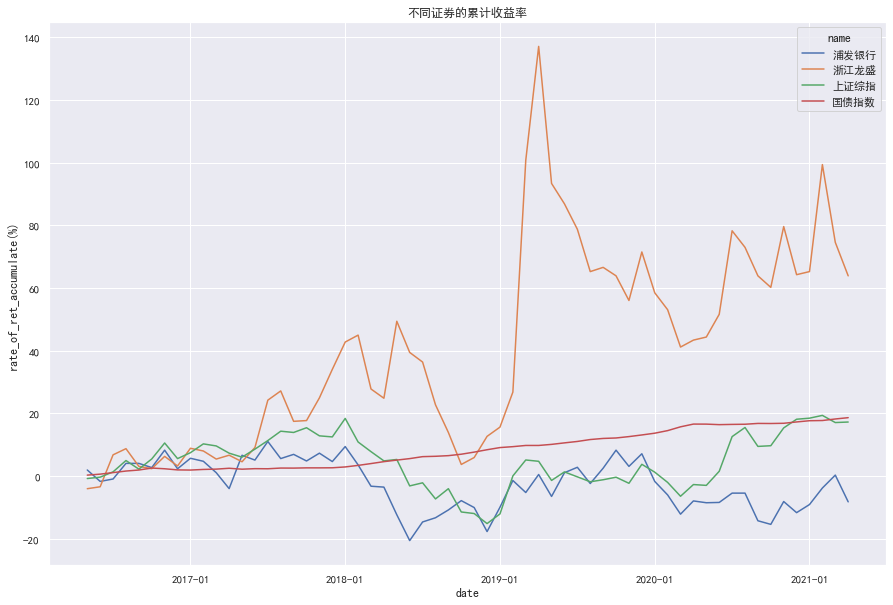

In [5]:
df = get_rate_of_ret()
df.reset_index(drop=True, inplace=True)
print(df.head())


sns.set(font="simhei")
plt.rcParams["axes.unicode_minus"] = False

plt.figure(figsize=(15, 10))
plt.title("不同证券的月度收益率")
plt.xticks(get_xticks(df["date"]))

fig = sns.lineplot(x="date", y="rate_of_ret(%)", hue="name", data=df)
fig = fig.get_figure()
fig.savefig("./output/rate_of_return.png")
plt.close()

plt.figure(figsize=(15, 10))
plt.title("不同证券的累计收益率")
plt.xticks(get_xticks(df["date"]))

fig = sns.lineplot(x="date", y="rate_of_ret_accumulate(%)", hue="name", data=df)
fig = fig.get_figure()
fig.savefig("./output/rate_of_return_accumulate.png")